# Import, Set working directory

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time
import xgboost as xgb
import shap

from xgboost import XGBClassifier

from scipy import stats
from scipy.stats import randint

from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import SVR


from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 

%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
def main():
    print("Current Working Directory " , os.getcwd())
    if os.path.exists("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia") :
        # Change the current working Directory    
        os.chdir("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia")
        print("New Working Directory " , os.getcwd())
    else:
        print("Can't change the Current Working Directory")    
        print("Current Working Directory " , os.getcwd())
if __name__ == '__main__':
    main()

Current Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia
New Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Classes

# Data Preparation Class
- Read Data - !Drop Unnamed was commented!
- X_and_y: Standard Deviation Filter - !For this document the filter was commented! We do not want to loose any columns
- Split Function
- Smote Upsampling


In [4]:
class DataPrep:
    def __init__(self, seed):
        self.seed = seed
    
  # Read Data
    def read_data(self, path, nrows, usecols):
        data = pd.read_csv(path, nrows=nrows, usecols=usecols)
        data.index = data.iloc[:,0]
        #data.drop(columns = "Unnamed: 0", inplace = True)
        data.columns = [(re.sub('\.\d+', '', gene)) for gene in data.columns]
        return data
  
  # Filter with Standard Deviation Threshold
    def X_and_y(self, data, threshold):
        X = data.drop(columns = 'label')
        #X_sd = X.loc[:, X.std() >= threshold]
        y = data[["label"]]
        return X, y
  
  # Train Test Split data
    def split(self, X, y, test_size):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=self.seed)
        return X_train, X_test, y_train, y_test
  
  # Upsample unbalanced data
    def smote_up(self, X_train, y_train):
        #print("Before OverSampling, counts of label '1': {}".format(sum(y_train['label']==1)))
        #print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train['label']==0)))

        sm = SMOTE(random_state=self.seed)
        X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

        #print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
        #print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

        #print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
        #print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))
        column_names = X_train.columns

        # Make dataframe again
        X_train_smote = pd.DataFrame(X_train_smote, columns=column_names)
        y_train_smote = pd.DataFrame(y_train_smote, columns=['label'])

        return X_train_smote, y_train_smote
    
    def bulbasaur(self, path, threshold = 2, nrows = None, usecols = None):
        data = self.read_data(path, nrows, usecols)
        X, y = self.X_and_y(data, threshold)
        X_train, X_test, y_train, y_test = self.split(X, y, 0.05)
        X_train_smote, y_train_smote = self.smote_up(X_train, y_train)
        return X_train_smote, y_train_smote, X_test, y_test
    
dataprep = DataPrep(1888)

# XGBoost Multi-Label Classifier

## Load Data and Top Genes

In [ ]:
top_genes = pd.read_csv("Output/Results/Top_genes/top_genes_1.0.csv")
top_genes = top_genes["top_genes"].tolist()
top_genes.append("label")

## Hyperparameter Tuning

In [ ]:
X_train, y_train, X_test, y_test = dataprep.bulbasaur("Output/Chunk_AllCancers_1only.csv", usecols = top_genes)

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(num_class = 6)

cv_params = {'max_depth': [7, 11], 
             'min_child_weight': [1,2], 
             'n_estimators': [500, 1500], 
             'learning_rate': [0.1, 0.2], 
             'subsample': [0.6, 0.8], 
             'colsample_bytree': [0.5, 0.8], 
             'gamma': [0.1, 0.5],
             'seed':[1888],
             'objective': ['multi:softmax']}

optimized_GBM = GridSearchCV(xgb, 
                             cv_params, 
                             scoring = 'accuracy', 
                             cv = 3, 
                             n_jobs = -1,
                             verbose = 2) 

optimized_GBM.fit(X_train, y_train)

print(optimized_GBM.best_score_)
print(optimized_GBM.best_params_)

results = pd.DataFrame({"Best Score": optimized_GBM.best_score_, "Best Params": (optimized_GBM.best_params_)})
results.to_csv("Tune_XGBoost.csv")

# Optimize for accuracy since that is the metric used in the Adult Data Set notation

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 100.9min


In [38]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class = 2)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=8, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [16]:
optimized_GBM.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'objective': 'multi:softmax',
 'seed': 0,
 'subsample': 0.8}

In [1]:
x = {'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'objective': 'multi:softmax',
 'seed': 0,
 'subsample': 0.8}
y = 0.6721256684491979

In [2]:
pd.DataFrame({"x":x, "y":y})

,x,y
colsample_bytree,0.8,0.672126
gamma,0.1,0.672126
learning_rate,0.1,0.672126
max_depth,7,0.672126
min_child_weight,1,0.672126
n_estimators,1000,0.672126
objective,multi:softmax,0.672126
seed,0,0.672126
subsample,0.8,0.672126


In [17]:
optimized_GBM.best_score_
optimized_GBM.best_params_

0.6721256684491979

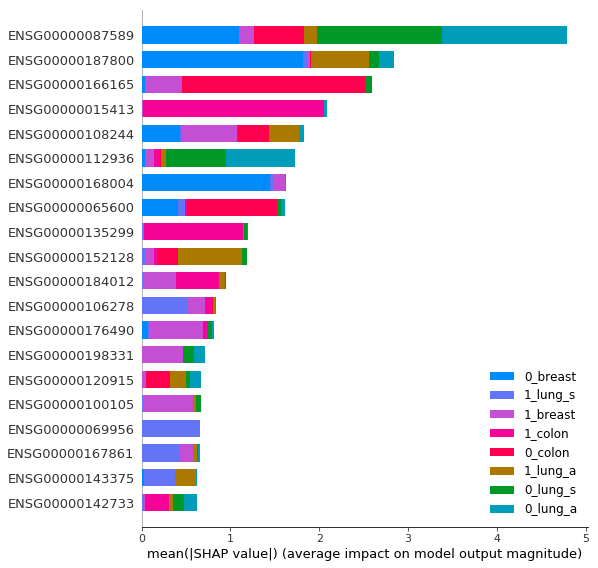

In [51]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(100, axis = 1, random_state = 562001),approximate=True)
shap.summary_plot(shap_values, X_test.sample(100, axis = 1, random_state = 562001), plot_type="bar", class_names = model.classes_)

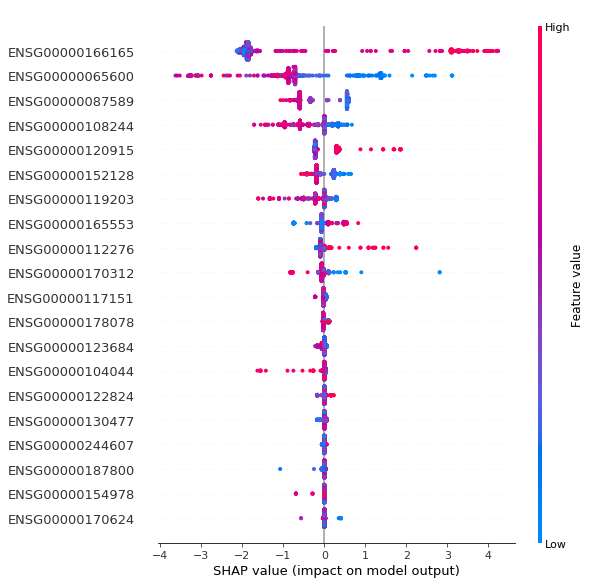

In [56]:
shap.summary_plot(shap_values[1], X_test.sample(100, axis = 1, random_state = 562001))

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])